In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.seasonal import STL
from pandas.tseries.frequencies import to_offset

In [3]:
df = pd.read_parquet('TRAIN_Reco_2021_2022_2023.parquet.gzip').reset_index()
df.head()

,ExecutionTime,ID,high,low,close,volume
0,2021-01-06 21:45:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0
1,2021-01-06 22:00:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0
2,2021-01-06 22:15:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0
3,2021-01-06 22:30:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0
4,2021-01-06 22:45:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0


In [4]:
print(df.isnull().sum())

ExecutionTime    0
ID               0
high             0
low              0
close            0
volume           0
dtype: int64


In [5]:
float_columns = df.select_dtypes(include=['float64', 'float32']).columns
df[float_columns] = df[float_columns].astype(np.float16)

print("Memory usage after conversion:", df.memory_usage(deep=True).sum() / 1024**2, "MB")

Memory usage after conversion: 4793.152713775635 MB


In [6]:
print("Memory usage:", df.memory_usage(deep=True).sum() / 1024**2, "MB")

Memory usage: 4793.152713775635 MB


In [7]:
# Convert 'ExecutionTime' to datetime
df['ExecutionTime'] = pd.to_datetime(df['ExecutionTime'])
print(type(df['ExecutionTime']))
df.set_index('ExecutionTime', inplace=True)
df.head()

<class 'pandas.core.series.Series'>


C:\Users\a4293604\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,ID,high,low,close,volume
ExecutionTime,,,,,
2021-01-06 21:45:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0
2021-01-06 22:00:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0
2021-01-06 22:15:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0
2021-01-06 22:30:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0
2021-01-06 22:45:00+01:00,Fri00Q1,0.0,0.0,0.0,0.0


In [19]:
# ------------------------------
# 4. Log Transformation
# ------------------------------
df['log_volume'] = np.where(df['volume'] > 0, np.log(df['volume']), 0)
df['log_low'] = np.where(df['low'] > 0, np.log(df['low']), 0)
df['log_close'] = np.where(df['close'] > 0, np.log(df['close']), 0)
df['log_high'] = np.where(df['high'] > 0, np.log(df['high']), 0)

C:\Users\a4293604\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


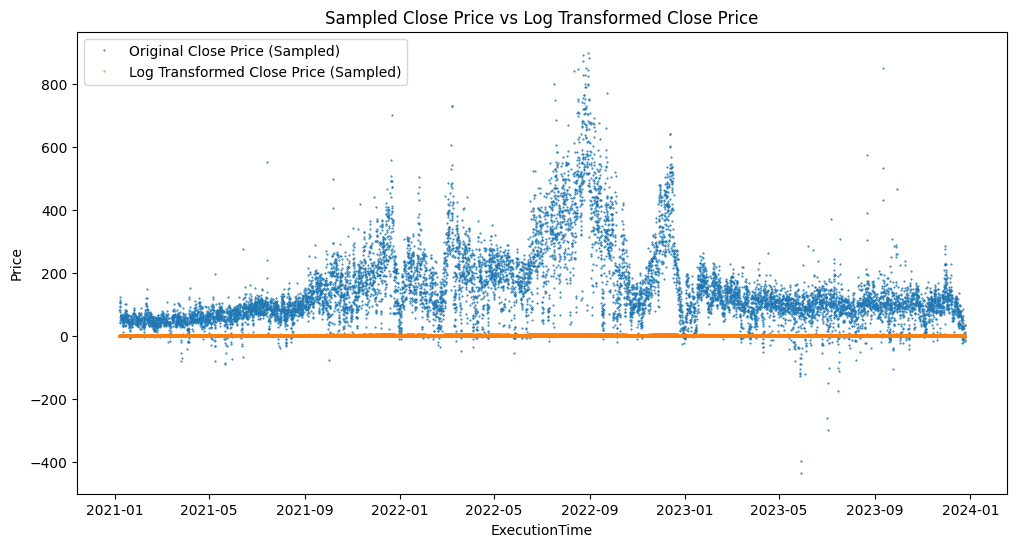

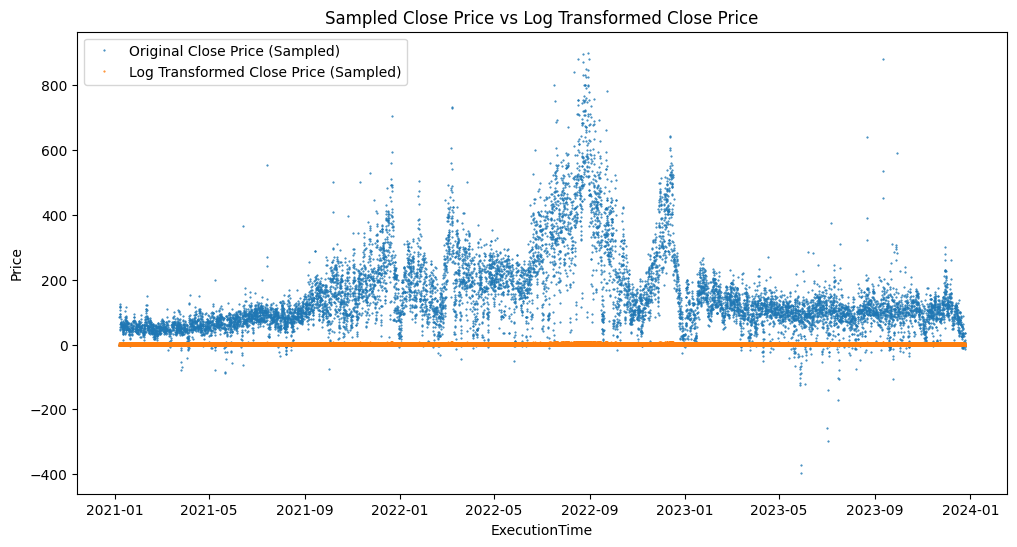

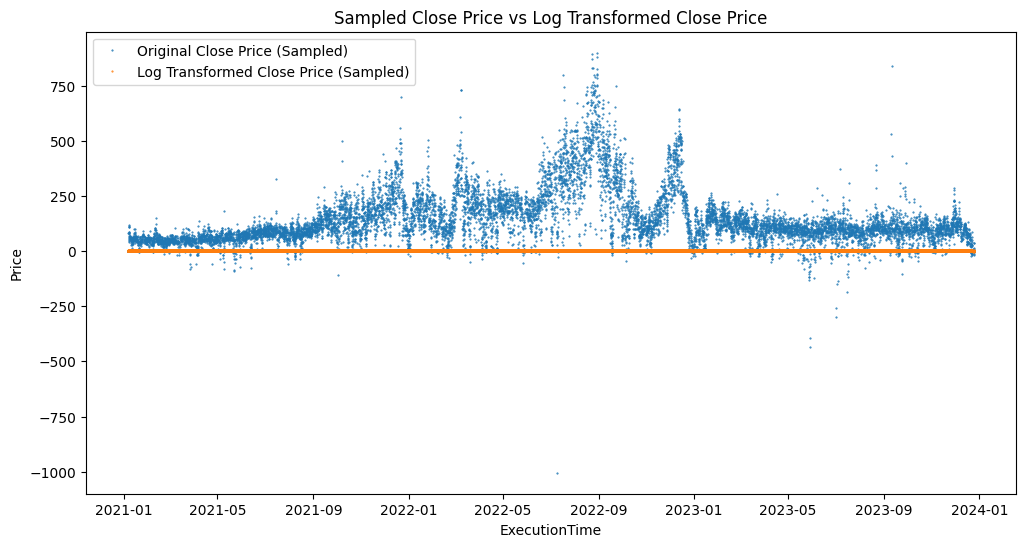

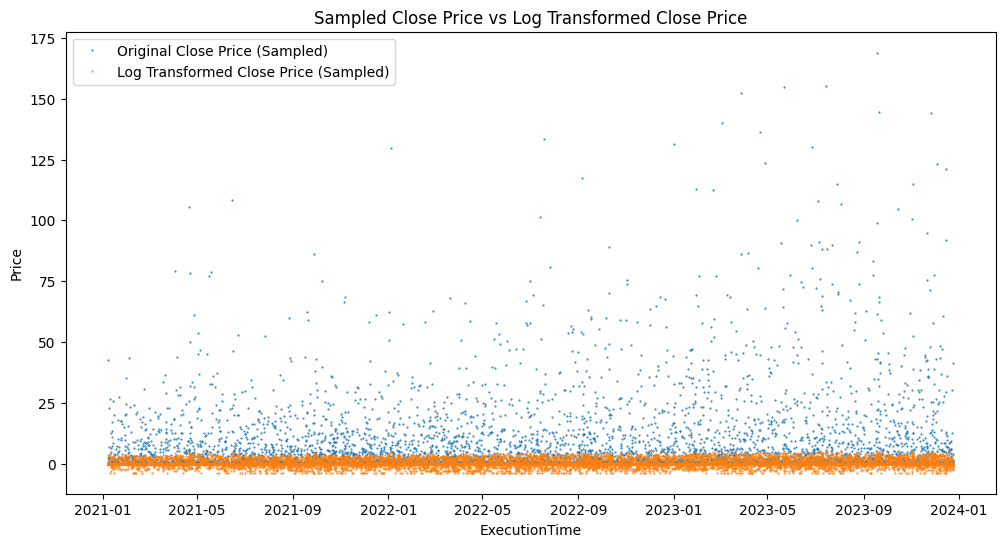

In [20]:
# Select 100,000 random samples out of 6 million
sampled_data = df.sample(n=100000, random_state=42)

# Plot the sampled data
plt.figure(figsize=(12, 6))
plt.plot(sampled_data.index, sampled_data['close'], '.', markersize=1, label='Original Close Price (Sampled)')
plt.plot(sampled_data.index, sampled_data['log_close'], '.', markersize=1, label='Log Transformed Close Price (Sampled)')
plt.legend()
plt.title('Sampled Close Price vs Log Transformed Close Price')
plt.xlabel('ExecutionTime')
plt.ylabel('Price')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(sampled_data.index, sampled_data['high'], '.', markersize=1, label='Original Close Price (Sampled)')
plt.plot(sampled_data.index, sampled_data['log_high'], '.', markersize=1, label='Log Transformed Close Price (Sampled)')
plt.legend()
plt.title('Sampled Close Price vs Log Transformed Close Price')
plt.xlabel('ExecutionTime')
plt.ylabel('Price')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(sampled_data.index, sampled_data['low'], '.', markersize=1, label='Original Close Price (Sampled)')
plt.plot(sampled_data.index, sampled_data['log_low'], '.', markersize=1, label='Log Transformed Close Price (Sampled)')
plt.legend()
plt.title('Sampled Close Price vs Log Transformed Close Price')
plt.xlabel('ExecutionTime')
plt.ylabel('Price')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(sampled_data.index, sampled_data['volume'], '.', markersize=1, label='Original Close Price (Sampled)')
plt.plot(sampled_data.index, sampled_data['log_volume'], '.', markersize=1, label='Log Transformed Close Price (Sampled)')
plt.legend()
plt.title('Sampled Close Price vs Log Transformed Close Price')
plt.xlabel('ExecutionTime')
plt.ylabel('Price')
plt.show()


In [ ]:
# ------------------------------
# 5. Differencing
# ------------------------------

# Non-Seasonal Differencing
df['diff_log_close'] = df['log_close'].diff()

# Seasonal Differencing (assuming daily seasonality: 96 intervals per day for 15-minute data)
seasonal_period = 96
df['seasonal_diff_log_cloe'] = df['log_close'] - df['log_close'].shift(seasonal_period)

# Combined Differenced Series
df['diff_seasonal_diff_log_close'] = df['diff_log_close'] - df['diff_log_close'].shift(seasonal_period)

# Drop NaN values resulted from differencing
df.dropna(inplace=True)

# Plot to visualize differencing
plt.figure(figsize=(12, 6))
plt.plot(df['diff_seasonal_diff_log_close'], label='Differenced Log Close')
plt.legend()
plt.title('Differenced Log Transformed Close')
plt.show()
